In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.models import load_model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.models import Model, load_model
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib notebook

In [5]:
df = pd.read_csv('GBPJPY_50.csv', delimiter=",").iloc[:, 1]
df = df.values
print(df, df.shape)

[ 138.437   138.42    138.485  ...,  143.5265  143.5045  143.501 ] (360696,)


In [6]:
window = 100
med = np.array([ np.mean(df[i-window:i+1]) for i in range(window, len(df))])
print(med.shape)

(360596,)


In [5]:
# %timeit
# window2 = 750
# med2 = np.array([np.mean(df[i-window2:i+1]) for i in range(window2, len(df))])
# print(med2)

In [9]:
window2 = 750
med2 = np.array(pd.ewma(pd.Series(df[window2:]), span=window2))
print(med2, med2.shape)

[ 138.0945      138.10226033  138.11186578 ...,  143.45119836  143.45134031
  143.45147256] (359946,)


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=750,adjust=True,ignore_na=False,min_periods=0).mean()
  


In [10]:
def do_renko(close,tam):
    renko=[]
    renko.append(close[0])
    actual_renko=close[0]
    
    for ii in range(1,len(close)):
        if(abs(actual_renko-close[ii])>=tam):
            if(close[ii]>actual_renko):
                renko.append(actual_renko+tam)
                actual_renko=actual_renko+tam
            else:
                renko.append(actual_renko-tam)
                actual_renko=actual_renko-tam
        else:
            renko.append(actual_renko) 
    return renko

In [11]:
renkos = np.array(do_renko(df, 0.3))
print(renkos.shape)

(360696,)


<IPython.core.display.Javascript object>


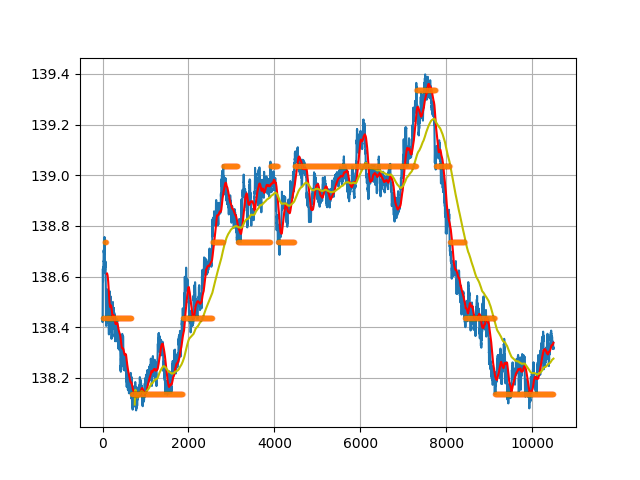

In [12]:
max_plot = min(10500, len(df))
plt.figure()
plt.plot(df[:max_plot])
plt.plot(np.arange(window, max_plot), med[:max_plot-window], 'r')
plt.plot(np.arange(window2, max_plot), med2[:max_plot-window2], 'y')
plt.plot(renkos[:max_plot], '.', alpha=0.05)
plt.grid()
plt.show()
plt.savefig('basic_price_2_means.png')

In [16]:
treshold = 0.01
points = np.array([ 0 if abs(med[window2-window+i]-med2[i]) > treshold else 1 for i in range(len(df)-window2)])
Counter(points)

Counter({0: 327453, 1: 32493})

In [17]:
# Get the 2 closest renkos for each point
renkos_pairs = []
for i,point in enumerate(points):
    closest_renko = renkos[window2+i]
    second_renko = 0
    for j in range(i):
        if renkos[window2+i-j] != closest_renko:   
            second_renko = renkos[window2+i-j]
            break
            
    renkos_pairs.append([closest_renko, second_renko])
    
renkos_pairs = np.array(renkos_pairs)
print(renkos_pairs)

KeyboardInterrupt: 

In [18]:
stop_mem = 50000
batch = 1

In [19]:
start_pred = 0
predict_window = 100
y_labels = np.array([ 1 if points[i+start_pred:i+predict_window].any() == 1 else 0 for i in range(len(points)-predict_window)])[(batch-1)*stop_mem:batch*stop_mem]
print(y_labels.shape)

(50000,)


In [20]:
x_data = pd.DataFrame({'prices': df[window2:len(df)-predict_window],
                       'med_s': med[window2-window:len(med)-predict_window]-df[window2:len(df)-predict_window],
                       'med_h': med2[:len(med2)-predict_window]-med[window2-window:len(med)-predict_window],
                       'renkos': renkos[window2:len(df)-predict_window]-med2[:len(med2)-predict_window]}).as_matrix()[(batch-1)*stop_mem:batch*stop_mem]
print(x_data[:5], x_data.shape)

[[ -4.32425743e-02   4.32425743e-02   1.38094500e+02   4.25000000e-02]
 [ -3.47149142e-02   2.69752475e-02   1.38110000e+02   3.47396667e-02]
 [ -2.44163983e-02   5.28217822e-03   1.38131000e+02   2.51342201e-02]
 [ -1.62685239e-02  -6.30198020e-03   1.38142000e+02   1.75705041e-02]
 [ -6.59127639e-03  -3.10148515e-02   1.38166500e+02   8.10612787e-03]] (50000, 4)


In [21]:
win_input = 444
x_data = np.array([x_data[i-win_input:i] for i in range(win_input, len(x_data))])[:-win_input]
y_labels = y_labels[win_input:]
print(x_data.shape, y_labels.shape)

(49112, 444, 4) (49556,)


In [16]:
# Params
kernel_size = 4
pooling = 2
filters = 4 # n of dimensions
shape_0 = x_data.shape[1]
shape_1 = x_data.shape[2]
print(shape_0, shape_1)

444 4


In [15]:
model = load_model('equity_ticks_4d_renkos.h5')

In [17]:
# # 11 -> 9 -> 7 -> 5 -> 3 -> 1 w/ 3 dimensions each -> flattened -> classification
# model = Sequential((
#     # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
#     # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
#     # the input timeseries, the activation of each filter at that position.
#     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear', input_shape=(shape_0, shape_1)),
#     MaxPooling1D(pool_size = 3),     # Downsample the output of convolution by 2X.
#     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
#     MaxPooling1D(pool_size = 3),
#     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
#     MaxPooling1D(pool_size = 3),
#     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
#     MaxPooling1D(pool_size = 3),
#     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
# #     Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='sigmoid'),
#     # MaxPooling1D(),
#     Flatten(),
#     Dense(128, activation="relu"),
#     Dense(256, activation="relu"),
#     Dense(256, activation="relu"),
#     Dense(128, activation="relu"),
#     Dense(64, activation="relu"),
#     Dense(32, activation="relu"),
#     Dense(1, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
# ))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 441, 4)            68        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 147, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 144, 4)            68        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 4)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 4)             68        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 4)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 4)             68        
__________

In [17]:
his = model.fit(x_data, y_labels, epochs=5, batch_size=64, validation_split=0.1)

Train on 44600 samples, validate on 4956 samples
Epoch 1/5
44600/44600 [==============================] - 10s - loss: 0.2133 - binary_accuracy: 0.9132 - val_loss: 0.3699 - val_binary_accuracy: 0.8458
Epoch 2/5
44600/44600 [==============================] - 9s - loss: 0.1772 - binary_accuracy: 0.9248 - val_loss: 0.4545 - val_binary_accuracy: 0.7916
Epoch 3/5
44600/44600 [==============================] - 9s - loss: 0.1428 - binary_accuracy: 0.9393 - val_loss: 0.4889 - val_binary_accuracy: 0.8063
Epoch 4/5
44600/44600 [==============================] - 9s - loss: 0.1397 - binary_accuracy: 0.9418 - val_loss: 0.6177 - val_binary_accuracy: 0.8095
Epoch 5/5
44600/44600 [==============================] - 9s - loss: 0.1241 - binary_accuracy: 0.9478 - val_loss: 0.4700 - val_binary_accuracy: 0.8448


<IPython.core.display.Javascript object>


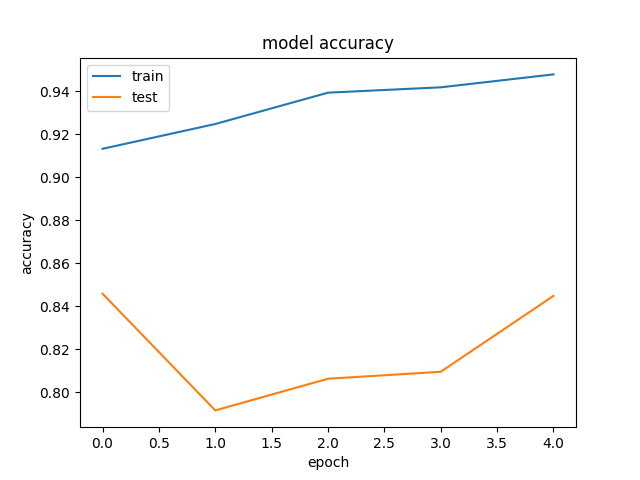

<IPython.core.display.Javascript object>


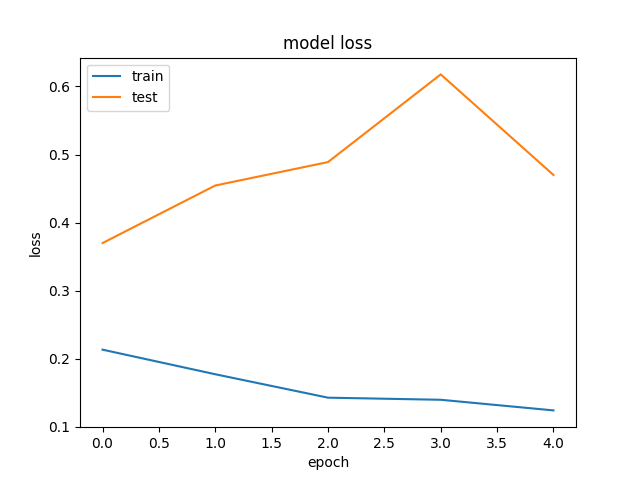

In [18]:
plt.figure()
# summarize history for accuracy
plt.plot(his.history['binary_accuracy'])
plt.plot(his.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Save model after training
model.save('equity_ticks_4d_renkos_post_processed.h5')

In [44]:
layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_data)

In [45]:
print(intermediate_output[:10])

[[ 25.27262688 -25.61691093  17.03749275  26.79856873]
 [ 25.97768211 -26.43593407  16.72770691  28.61499977]
 [ 26.82445717 -26.08034325  16.65940666  30.47023964]
 [ 27.80589485 -25.2527256   16.05370331  32.11413956]
 [ 29.82945061 -25.78027534  15.87939835  33.58822632]
 [ 30.01529121 -26.0461235   15.21254253  33.2948494 ]
 [ 28.27539444 -25.74697876  15.85633087  32.38470078]
 [ 27.88139915 -26.40123177  16.41259766  33.09260941]
 [ 27.63462639 -27.95143127  16.40968132  33.65763855]
 [ 25.97135735 -28.5715313   16.59339714  34.08050919]]


<IPython.core.display.Javascript object>


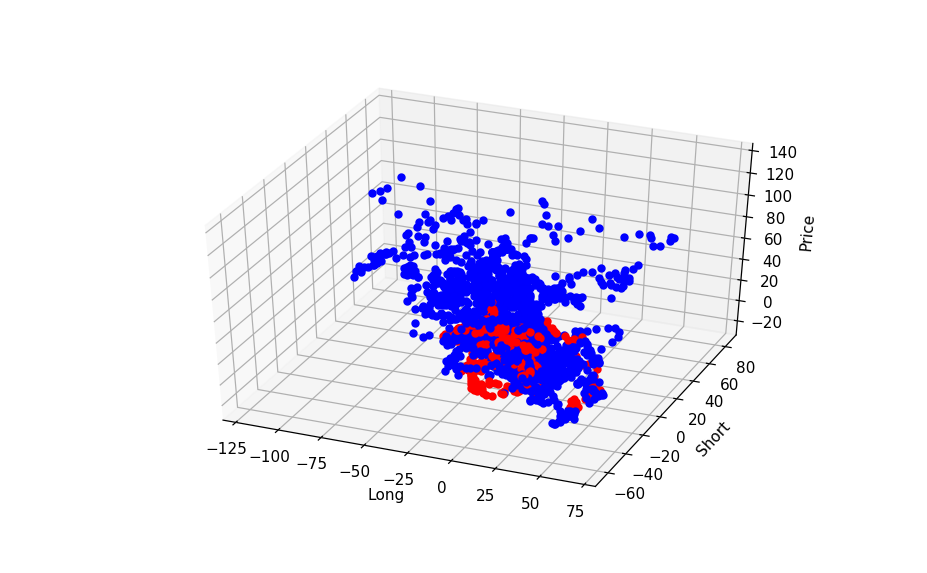

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,p in enumerate(intermediate_output):
    if i%2 == 0:
        if y_labels[i] == 1:
            ax.scatter(p[0], p[1], p[2], zdir='z', c= 'red')
        else:
            ax.scatter(p[0], p[1], p[2], zdir='z', c= 'blue')

ax.set_xlabel('Long')
ax.set_ylabel('Short')
ax.set_zlabel('Price')
plt.show()
plt.savefig('3D_representation.png')
del intermediate_layer_model
del intermediate_output

In [19]:
predicts = model.predict(x_data[:max_plot])

<IPython.core.display.Javascript object>


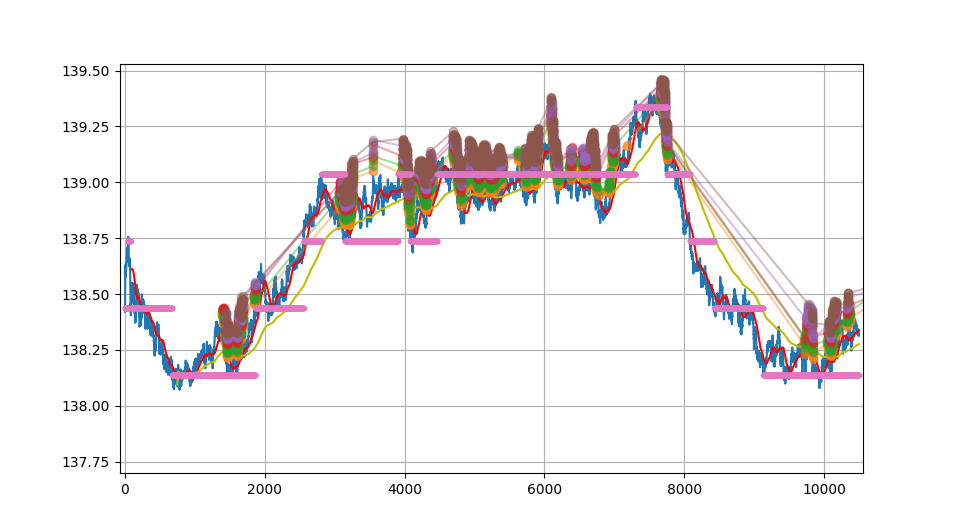

0.4 (2489,)
1194
0.5 (2355,)
1194
0.7 (2032,)
1194
0.8 (1788,)
1194
0.9 (1485,)
1194


In [20]:
plt.figure()
plt.plot(df[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot])
plt.plot(np.arange(window, max_plot), med[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot-window], 'r')
plt.plot(np.arange(window2, max_plot), med2[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot-window2], 'y')

for prob in [.4, .5, .7, .8, .9]:
    
    # Catch points above certain prob
    x_coord = []
    for i,pred in enumerate(predicts):
        if pred >= prob:
            x_coord.append(i)

    y_coord = np.array([df[(batch-1)*stop_mem+window2+win_input+i]+0.2*prob for i in x_coord])
    x_coord = np.array([i+window2+win_input for i in x_coord ])
    print(prob, x_coord.shape)
    plt.plot(x_coord, y_coord, '-o', alpha =0.4)
    print((batch-1)*stop_mem+window2+win_input)
    
# Plot graph
plt.plot(renkos[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot], '.', alpha=0.5)
plt.grid()  
plt.show()

195 updated from 0 to [ 0.44182482] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
196 updated from [ 0.44182482] to [ 0.49279195] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
197 updated from [ 0.49279195] to [ 0.51055974] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
204 updated from [ 0.51055974] to [ 0.51556134] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
205 updated from [ 0.51556134] to [ 0.58479404] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
208 updated from [ 0.58479404] to [ 0.6122328] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
211 updated from [ 0.6122328] to [ 0.64576143] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
212 updated from [ 0.64576143] to [ 0.708947] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
213 updated from [ 0.708947] to [ 0.73124236] for renkos [ 138.137    0.   ] last [ 138.137    0.   ]
214 updated from [ 0.73124236] to [ 0.7530725] for renkos [ 138.137    0.   ] last

<IPython.core.display.Javascript object>


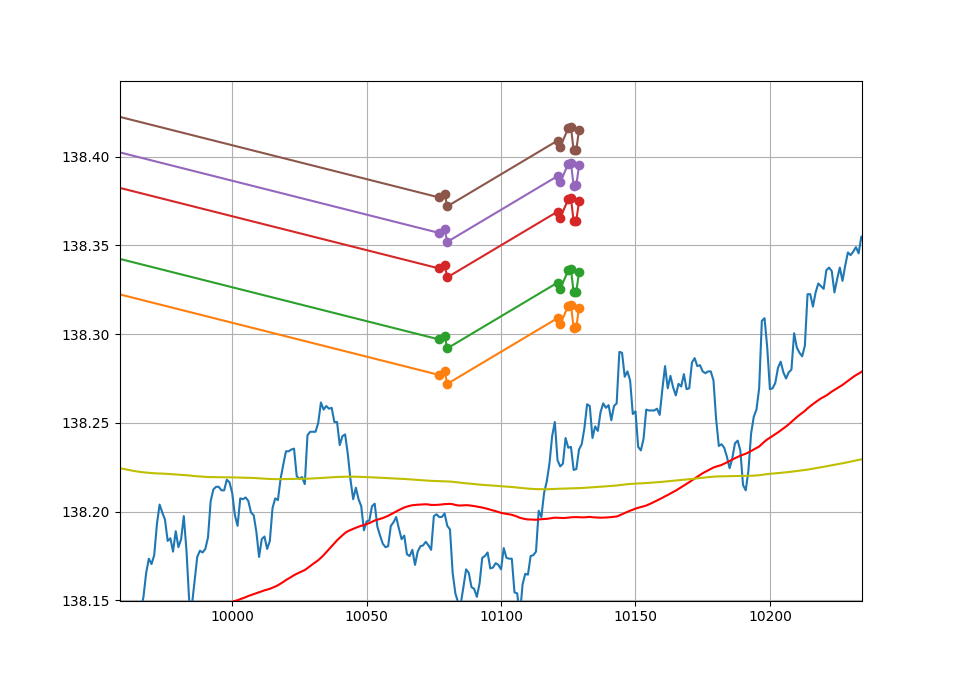

0.4 (71,)
1194
0.5 (69,)
1194
0.7 (64,)
1194
0.8 (59,)
1194
0.9 (58,)
1194


In [21]:
last_prob, last_renkos, first = 0, None, True
j,k,l = 0,0,0
for i,pred in enumerate(predicts):
    actual_renkos = renkos_pairs[(batch-1)*stop_mem+i] # renkos[(batch-1)*stop_mem:batch*stop_mem]
    actual_prob = pred
    if not first:
        if actual_prob > 0.4:
            j+=1
            if last_renkos.tolist() == actual_renkos.tolist() or last_renkos.tolist() == actual_renkos[::-1].tolist():
                l+=1
                if actual_prob < last_prob:
                    k+=1
                    predicts[i] = 0.009834
                else:
                    print(i, "updated from", last_prob, "to", actual_prob, "for renkos", actual_renkos, "last", last_renkos)
                    last_prob = actual_prob 
            else:
                last_prob = 0
    last_renkos = actual_renkos # renkos[(batch-1)*stop_mem:batch*stop_mem]
    first = None

# print(Counter(predicts))
print(j,k,l)
    
plt.figure()
plt.plot(df[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot])
plt.plot(np.arange(window, max_plot), med[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot-window], 'r')
plt.plot(np.arange(window2, max_plot), med2[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot-window2], 'y')

for prob in [.4, .5, .7, .8, .9]:
    
    # Catch points above certain prob
    x_coord = []
    for i,pred in enumerate(predicts):
        if pred >= prob:
            x_coord.append(i)

    y_coord = np.array([df[(batch-1)*stop_mem+window2+win_input+i]+0.2*prob for i in x_coord])
    x_coord = np.array([i+window2+win_input for i in x_coord ])
    print(prob, x_coord.shape)
    plt.plot(x_coord, y_coord, '-o')
    print((batch-1)*stop_mem+window2+win_input)
    
# Plot graph
plt.plot(renkos[(batch-1)*stop_mem:(batch-1)*stop_mem+max_plot], '.', alpha=0.5)
plt.grid()  
plt.show()

<IPython.core.display.Javascript object>


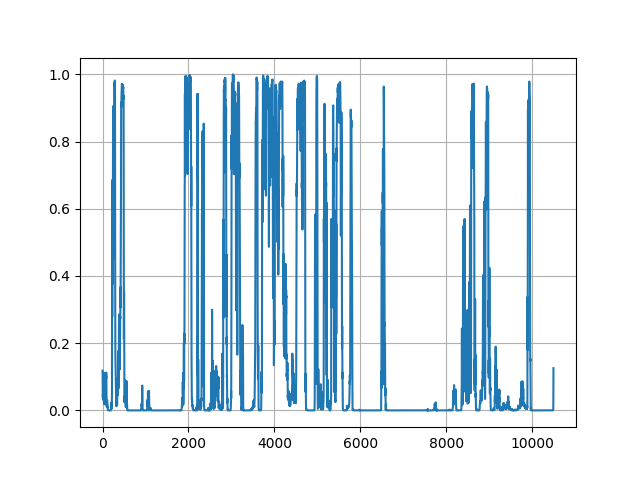

In [51]:
plt.figure()
plt.plot(predicts)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


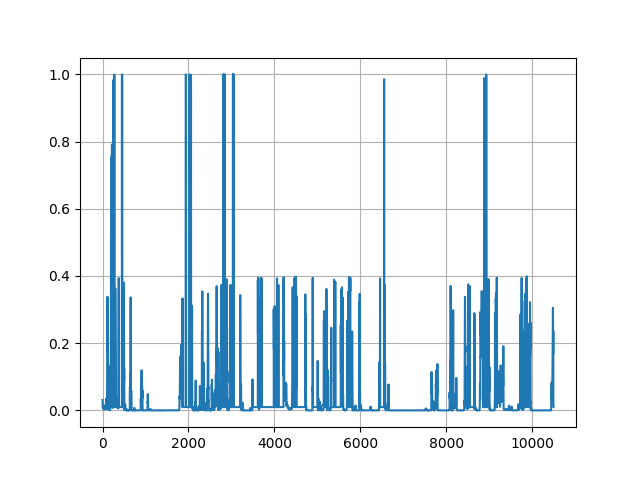

In [22]:
plt.figure()
plt.plot(predicts)
plt.grid()
plt.show()

In [40]:
import requests

In [44]:
 r = requests.post('http://localhost:5000/api/', data = {'key':'51363066', 'data': x_data[-2:]}).json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
print(r)